<a href="https://colab.research.google.com/github/adhyapratheesh/SkillSync/blob/main/Demo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. Dataset Preparation
# Load the datasets
employees_df = pd.read_csv('employee-dataset.csv')
projects_df = pd.read_csv('project-dataset.csv')

# Let's examine the data first
print("Employees dataset shape:", employees_df.shape)
print("Projects dataset shape:", projects_df.shape)

# Check for missing values
print("Missing values in employees dataset:\n", employees_df.isnull().sum())
print("Missing values in projects dataset:\n", projects_df.isnull().sum())


Employees dataset shape: (100, 4)
Projects dataset shape: (50, 4)
Missing values in employees dataset:
 Employee ID       0
Employee Name     0
Skills            0
Skills Ratings    0
dtype: int64
Missing values in projects dataset:
 Project ID               0
Project Name             0
Skills Needed            0
Team Members Required    0
dtype: int64


In [ ]:
def process_employee_skills(df):
    # Create a dictionary to store skill ratings for each employee
    employee_skills = {}

    # Define the skill list from our data
    skill_list = ['Python', 'Java', 'Project Management', 'Data Analysis',
                 'Communication', 'Teamwork', 'SQL', 'Machine Learning',
                 'Problem Solving', 'Critical Thinking']

    # Process each employee
    for _, row in df.iterrows():
        emp_id = row['Employee ID']
        skills = row['Skills'].split(',')
        ratings = [int(r) for r in row['Skills Ratings'].split(',')]

        # Create a dictionary of skills and their ratings
        skill_dict = {skill.strip(): 0 for skill in skill_list}  # Initialize all skills to 0
        for skill, rating in zip(skills, ratings):
            skill_dict[skill.strip()] = rating

        employee_skills[emp_id] = skill_dict

    # Convert to DataFrame
    skill_matrix = pd.DataFrame.from_dict(employee_skills, orient='index')
    skill_matrix.index.name = 'Employee ID'
    return skill_matrix.reset_index()

In [ ]:
def process_project_skills(df):
    # Create a dictionary to store required skills for each project
    project_skills = {}

    # Define the skill list from our data
    skill_list = ['Python', 'Java', 'Project Management', 'Data Analysis',
                 'Communication', 'Teamwork', 'SQL', 'Machine Learning',
                 'Problem Solving', 'Critical Thinking']

    # Process each project
    for _, row in df.iterrows():
        proj_id = row['Project ID']
        skills = row['Skills Needed'].split(',')

        # Create a binary indication of skills needed
        skill_dict = {skill.strip(): 0 for skill in skill_list}  # Initialize all skills to 0
        for skill in skills:
            skill_dict[skill.strip()] = 1

        # Add team size requirement
        skill_dict['Team Members Required'] = row['Team Members Required']

        project_skills[proj_id] = skill_dict

    # Convert to DataFrame
    skill_matrix = pd.DataFrame.from_dict(project_skills, orient='index')
    skill_matrix.index.name = 'Project ID'
    return skill_matrix.reset_index()

# Process the datasets
employee_skill_matrix = process_employee_skills(employees_df)
project_skill_matrix = process_project_skills(projects_df)

print("Employee skill matrix shape:", employee_skill_matrix.shape)
print("Project skill matrix shape:", project_skill_matrix.shape)

# 2. Feature Engineering
# For this model, we'll create training data by generating employee-project pairs
# and labeling them as suitable or not based on skill matching

Employee skill matrix shape: (100, 11)
Project skill matrix shape: (50, 12)


In [ ]:
def generate_suitability_score(employee_skills, project_skills):
    """
    Calculate a suitability score between 0 and 1 based on how well an employee's skills
    match a project's requirements.
    """
    total_required_skills = sum(project_skills.values())
    if total_required_skills == 0:
        return 0

    skill_match_score = 0
    for skill, required in project_skills.items():
        if required == 1 and skill in employee_skills:
            # Weight the score by the employee's rating in that skill
            skill_match_score += employee_skills[skill] / 5  # Normalize by max rating

    # Normalize by number of required skills
    return skill_match_score / total_required_skills

In [ ]:
def create_training_data(employee_df, project_df):
    """
    Create training data by pairing employees with projects and calculating suitability.
    """
    training_data = []

    # Get skill columns (excluding ID columns and Team Members Required)
    skill_columns = [col for col in project_df.columns if col not in ['Project ID', 'Team Members Required']]

    # For each project
    for p_idx, project in project_df.iterrows():
        project_id = project['Project ID']
        project_skills = {skill: project[skill] for skill in skill_columns}
        team_size = project['Team Members Required']

        # For each employee
        employee_scores = []
        for e_idx, employee in employee_df.iterrows():
            employee_id = employee['Employee ID']
            employee_skills = {skill: employee[skill] for skill in skill_columns}

            # Calculate suitability score
            score = generate_suitability_score(employee_skills, project_skills)
            employee_scores.append((employee_id, score))

        # Sort employees by suitability score
        employee_scores.sort(key=lambda x: x[1], reverse=True)

        # Label top team_size employees as suitable (1), others as not suitable (0)
        for i, (emp_id, score) in enumerate(employee_scores):
            is_suitable = 1 if i < team_size else 0

            # Get employee skills as features
            emp_data = employee_df[employee_df['Employee ID'] == emp_id].iloc[0].to_dict()
            proj_data = project_df[project_df['Project ID'] == project_id].iloc[0].to_dict()

            # Create feature vector
            features = {
                'Employee ID': emp_id,
                'Project ID': project_id,
            }

            # Add employee skills and ratings
            for skill in skill_columns:
                features[f'Employee_{skill}'] = emp_data[skill]

            # Add project requirements
            for skill in skill_columns:
                features[f'Project_{skill}'] = proj_data[skill]

            features['Team Size'] = team_size
            features['Suitability_Score'] = score
            features['Suitable'] = is_suitable

            training_data.append(features)

    return pd.DataFrame(training_data)

In [ ]:
# Create training dataset
training_df = create_training_data(employee_skill_matrix, project_skill_matrix)
print("Training dataset shape:", training_df.shape)

# 3. Data Splitting
# Define features and target
X = training_df.drop(['Employee ID', 'Project ID', 'Suitable'], axis=1)
y = training_df['Suitable']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training dataset shape: (5000, 25)
Training set shape: (3500, 22)
Validation set shape: (750, 22)
Test set shape: (750, 22)


In [ ]:
# 4. Algorithm Selection & 5. Model Training
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000)
}

# Initial model evaluation with cross-validation
print("Initial model evaluation with 5-fold cross-validation:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Initial model evaluation with 5-fold cross-validation:
Random Forest: 0.9811 (+/- 0.0043)
Gradient Boosting: 0.9789 (+/- 0.0029)
XGBoost: 0.9831 (+/- 0.0023)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 2654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 2800, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052143 -> initscore=-2.900217
[LightGBM] [Info] Start training from score -2.900217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
# 6. Hyperparameter Tuning
# We'll focus on tuning the top 3 performing models based on the initial evaluation
# For brevity, let's just tune Random Forest and XGBoost as examples

# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Perform grid search
rf_grid_search = GridSearchCV(models['Random Forest'], rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

xgb_grid_search = GridSearchCV(models['XGBoost'], xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest parameters for Random Forest:")
print(rf_grid_search.best_params_)
print(f"Best cross-validation score: {rf_grid_search.best_score_:.4f}")

print("\nBest parameters for XGBoost:")
print(xgb_grid_search.best_params_)
print(f"Best cross-validation score: {xgb_grid_search.best_score_:.4f}")


Best parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9817

Best parameters for XGBoost:
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score: 0.9851


In [ ]:
# Update models with best parameters
best_models = {
    'Random Forest': rf_grid_search.best_estimator_,
    'XGBoost': xgb_grid_search.best_estimator_,
    'Gradient Boosting': models['Gradient Boosting'],  # Using default parameters
    'LightGBM': models['LightGBM'],  # Using default parameters
    'SVM': models['SVM'],  # Using default parameters
    'Neural Network': models['Neural Network']  # Using default parameters
}

# 7. Model Evaluation on Validation Set
validation_results = {}

for name, model in best_models.items():
    # Train the model if it hasn't been trained during grid search
    if name not in ['Random Forest', 'XGBoost']:
        model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    validation_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    print(f"\n{name} Validation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

# Find the best model based on F1 score (balancing precision and recall)
best_model_name = max(validation_results, key=lambda x: validation_results[x]['f1'])
print(f"\nBest model based on F1 score: {best_model_name}")

# 8. Final Model Testing
final_model = best_models[best_model_name]
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate final metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print("\nFinal Model Test Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Random Forest Validation Results:
Accuracy: 0.9880
Precision: 0.9688
Recall: 0.7949
F1 Score: 0.8732
ROC AUC: 0.9977

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       711
           1       0.97      0.79      0.87        39

    accuracy                           0.99       750
   macro avg       0.98      0.90      0.93       750
weighted avg       0.99      0.99      0.99       750


XGBoost Validation Results:
Accuracy: 0.9907
Precision: 0.9444
Recall: 0.8718
F1 Score: 0.9067
ROC AUC: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       711
           1       0.94      0.87      0.91        39

    accuracy                           0.99       750
   macro avg       0.97      0.93      0.95       750
weighted avg       0.99      0.99      0.99       750


Gradient Boosting Validation Results:
Accuracy: 0.9773
Precision: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


SVM Validation Results:
Accuracy: 0.9480
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.9814

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       711
           1       0.00      0.00      0.00        39

    accuracy                           0.95       750
   macro avg       0.47      0.50      0.49       750
weighted avg       0.90      0.95      0.92       750


Neural Network Validation Results:
Accuracy: 0.9880
Precision: 0.9412
Recall: 0.8205
F1 Score: 0.8767
ROC AUC: 0.9930

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       711
           1       0.94      0.82      0.88        39

    accuracy                           0.99       750
   macro avg       0.97      0.91      0.94       750
weighted avg       0.99      0.99      0.99       750


Best model based on F1 score: XGBoost

Final Model Test Results:
Accur

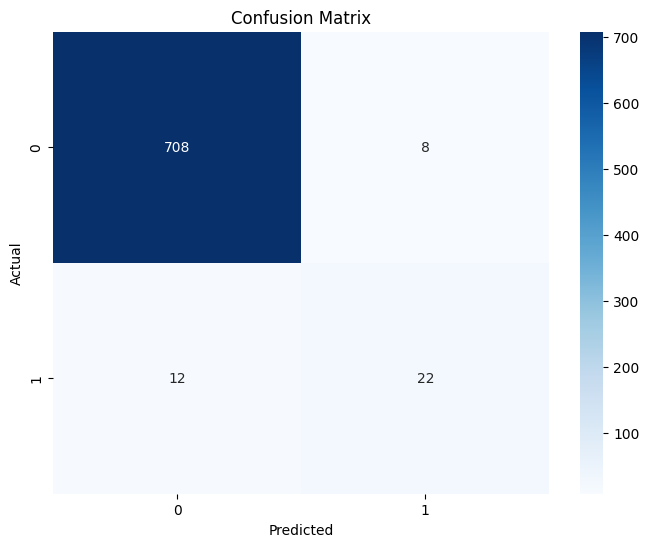

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

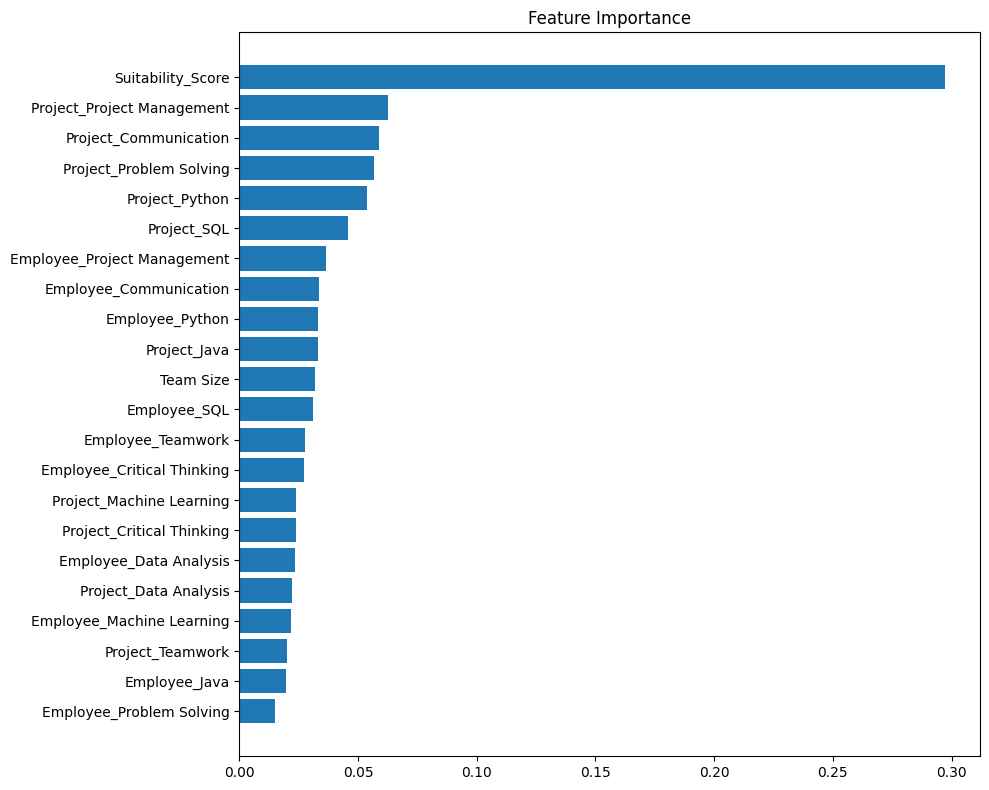

In [ ]:
# Feature Importance Analysis
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    feature_importance = final_model.feature_importances_
    feature_names = X_train.columns
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

In [ ]:

# 9. Deployment - Creating a function to predict team members for a project
def predict_team_for_project(project_id, n_team_members=None):
    """
    Predict the most suitable team members for a given project.

    Args:
        project_id: The ID of the project
        n_team_members: Number of team members to recommend (default: use project's required team size)

    Returns:
        List of recommended employee IDs sorted by suitability
    """
    project = project_skill_matrix[project_skill_matrix['Project ID'] == project_id].iloc[0]

    if n_team_members is None:
        n_team_members = int(project['Team Members Required'])

    # Create feature vectors for each employee paired with this project
    features_list = []
    employee_ids = []

    skill_columns = [col for col in project_skill_matrix.columns
                     if col not in ['Project ID', 'Team Members Required']]

    for _, employee in employee_skill_matrix.iterrows():
        emp_id = employee['Employee ID']
        employee_ids.append(emp_id)

        features = {}

        # Add employee skills
        for skill in skill_columns:
            features[f'Employee_{skill}'] = employee[skill]

        # Add project requirements
        for skill in skill_columns:
            features[f'Project_{skill}'] = project[skill]

        features['Team Size'] = project['Team Members Required']

        # Calculate suitability score
        emp_skills = {skill: employee[skill] for skill in skill_columns}
        proj_skills = {skill: project[skill] for skill in skill_columns}
        score = generate_suitability_score(emp_skills, proj_skills)
        features['Suitability_Score'] = score

        features_list.append(features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)

    # Predict suitability probability
    proba = final_model.predict_proba(features_df)[:, 1]

    # Sort employees by probability of being suitable
    employee_proba = list(zip(employee_ids, proba))
    employee_proba.sort(key=lambda x: x[1], reverse=True)

    # Return top n_team_members
    recommended_team = [emp_id for emp_id, _ in employee_proba[:n_team_members]]
    return recommended_team

# Example: Predict team for a specific project
example_project_id = 10  # Choose a project ID from the dataset
recommended_team = predict_team_for_project(example_project_id)
print(f"\nRecommended team for Project {example_project_id}:")
print(recommended_team)

# Print details about the recommended team
print("\nTeam Member Details:")
for emp_id in recommended_team:
    emp = employees_df[employees_df['Employee ID'] == emp_id].iloc[0]
    print(f"Employee ID: {emp_id}, Name: {emp['Employee Name']}, Skills: {emp['Skills']}")

# 10. Continuous Improvement - In a real-world scenario, you would:
# - Collect feedback on team performance
# - Monitor model predictions vs actual outcomes
# - Periodically retrain the model with new data
# - Adjust features and algorithms based on performance

# For demonstration, let's create a function that would be used in a feedback loop
def update_model_with_feedback(actual_suitable_employees, predicted_suitable_employees, project_id):
    """
    This function would be used to incorporate feedback on model predictions.
    In a real system, this would collect data for retraining.

    Args:
        actual_suitable_employees: List of employee IDs who were actually suitable
        predicted_suitable_employees: List of employee IDs the model predicted as suitable
        project_id: The project ID
    """
    # In a real system, this data would be stored for later model retraining
    print(f"Feedback for Project {project_id}:")
    print(f"Correctly predicted employees: {set(actual_suitable_employees) & set(predicted_suitable_employees)}")
    print(f"Missed employees: {set(actual_suitable_employees) - set(predicted_suitable_employees)}")
    print(f"Incorrectly recommended employees: {set(predicted_suitable_employees) - set(actual_suitable_employees)}")

    # Accuracy of prediction
    total = len(set(actual_suitable_employees) | set(predicted_suitable_employees))
    correct = len(set(actual_suitable_employees) & set(predicted_suitable_employees))
    accuracy = correct / total if total > 0 else 0
    print(f"Feedback accuracy: {accuracy:.4f}")

# Example of feedback collection (simulated)
actual_team = [3, 15, 27, 42]  # This would come from real-world feedback
update_model_with_feedback(actual_team, recommended_team, example_project_id)


Recommended team for Project 10:
[93, 13, 29, 81]

Team Member Details:
Employee ID: 93, Name: Oscar Gordon, Skills: Python,Java,SQL,Critical Thinking
Employee ID: 13, Name: Andrew Johnson, Skills: Python,Data Analysis,Problem Solving,Critical Thinking
Employee ID: 29, Name: Jacob Baker, Skills: Java,SQL,Critical Thinking,Problem Solving
Employee ID: 81, Name: Xavier Gonzalez, Skills: Python,Machine Learning,Critical Thinking,Problem Solving
Feedback for Project 10:
Correctly predicted employees: set()
Missed employees: {3, 42, 27, 15}
Incorrectly recommended employees: {81, 29, 93, 13}
Feedback accuracy: 0.0000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier

# Function to process employee skills
def process_employee_skills(df):
    # Create a dictionary to store skill ratings for each employee
    employee_skills = {}

    # Define the skill list from our data
    skill_list = ['Python', 'Java', 'Project Management', 'Data Analysis',
                 'Communication', 'Teamwork', 'SQL', 'Machine Learning',
                 'Problem Solving', 'Critical Thinking']

    # Process each employee
    for _, row in df.iterrows():
        emp_id = row['Employee ID']
        skills = row['Skills'].split(',')
        ratings = [int(r) for r in row['Skills Ratings'].split(',')]

        # Create a dictionary of skills and their ratings
        skill_dict = {skill.strip(): 0 for skill in skill_list}  # Initialize all skills to 0
        for skill, rating in zip(skills, ratings):
            skill_dict[skill.strip()] = rating

        employee_skills[emp_id] = skill_dict

    # Convert to DataFrame
    skill_matrix = pd.DataFrame.from_dict(employee_skills, orient='index')
    skill_matrix.index.name = 'Employee ID'
    return skill_matrix.reset_index()

# Function to process project skills
def process_project_skills(df):
    # Create a dictionary to store required skills for each project
    project_skills = {}

    # Define the skill list from our data
    skill_list = ['Python', 'Java', 'Project Management', 'Data Analysis',
                 'Communication', 'Teamwork', 'SQL', 'Machine Learning',
                 'Problem Solving', 'Critical Thinking']

    # Process each project
    for _, row in df.iterrows():
        proj_id = row['Project ID']
        skills = row['Skills Needed'].split(',')

        # Create a binary indication of skills needed
        skill_dict = {skill.strip(): 0 for skill in skill_list}  # Initialize all skills to 0
        for skill in skills:
            skill_dict[skill.strip()] = 1

        # Add team size requirement
        skill_dict['Team Members Required'] = row['Team Members Required']

        project_skills[proj_id] = skill_dict

    # Convert to DataFrame
    skill_matrix = pd.DataFrame.from_dict(project_skills, orient='index')
    skill_matrix.index.name = 'Project ID'
    return skill_matrix.reset_index()

# Calculate suitability score between employee and project
def generate_suitability_score(employee_skills, project_skills):
    """
    Calculate a suitability score between 0 and 1 based on how well an employee's skills
    match a project's requirements.
    """
    total_required_skills = sum(project_skills.values())
    if total_required_skills == 0:
        return 0

    skill_match_score = 0
    for skill, required in project_skills.items():
        if required == 1 and skill in employee_skills:
            # Weight the score by the employee's rating in that skill
            skill_match_score += employee_skills[skill] / 5  # Normalize by max rating

    # Normalize by number of required skills
    return skill_match_score / total_required_skills

# Create training data from employee-project pairs
def create_training_data(employee_df, project_df):
    """
    Create training data by pairing employees with projects and calculating suitability.
    """
    training_data = []

    # Get skill columns (excluding ID columns and Team Members Required)
    skill_columns = [col for col in project_df.columns if col not in ['Project ID', 'Team Members Required']]

    # For each project
    for p_idx, project in project_df.iterrows():
        project_id = project['Project ID']
        project_skills = {skill: project[skill] for skill in skill_columns}
        team_size = project['Team Members Required']

        # For each employee
        employee_scores = []
        for e_idx, employee in employee_df.iterrows():
            employee_id = employee['Employee ID']
            employee_skills = {skill: employee[skill] for skill in skill_columns}

            # Calculate suitability score
            score = generate_suitability_score(employee_skills, project_skills)
            employee_scores.append((employee_id, score))

        # Sort employees by suitability score
        employee_scores.sort(key=lambda x: x[1], reverse=True)

        # Label top team_size employees as suitable (1), others as not suitable (0)
        for i, (emp_id, score) in enumerate(employee_scores):
            is_suitable = 1 if i < team_size else 0

            # Get employee skills as features
            emp_data = employee_df[employee_df['Employee ID'] == emp_id].iloc[0].to_dict()
            proj_data = project_df[project_df['Project ID'] == project_id].iloc[0].to_dict()

            # Create feature vector
            features = {
                'Employee ID': emp_id,
                'Project ID': project_id,
            }

            # Add employee skills and ratings
            for skill in skill_columns:
                features[f'Employee_{skill}'] = emp_data[skill]

            # Add project requirements
            for skill in skill_columns:
                features[f'Project_{skill}'] = proj_data[skill]

            features['Team Size'] = team_size
            features['Suitability_Score'] = score
            features['Suitable'] = is_suitable

            training_data.append(features)

    return pd.DataFrame(training_data)

# Main script to build and evaluate the model
def build_employee_matching_model(employees_df, projects_df):
    # Process the datasets
    employee_skill_matrix = process_employee_skills(employees_df)
    project_skill_matrix = process_project_skills(projects_df)

    # Create training dataset
    training_df = create_training_data(employee_skill_matrix, project_skill_matrix)

    # Define features and target
    X = training_df.drop(['Employee ID', 'Project ID', 'Suitable'], axis=1)
    y = training_df['Suitable']

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Train and evaluate initial models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42)
    }

    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        print(f"{name} initial CV accuracy: {cv_scores.mean():.4f}")

    # Hyperparameter tuning for Random Forest
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Hyperparameter tuning for XGBoost
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }

    # Perform grid search
    rf_grid_search = GridSearchCV(models['Random Forest'], rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    rf_grid_search.fit(X_train, y_train)

    xgb_grid_search = GridSearchCV(models['XGBoost'], xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    xgb_grid_search.fit(X_train, y_train)

    # Update models with best parameters
    best_models = {
        'Random Forest': rf_grid_search.best_estimator_,
        'XGBoost': xgb_grid_search.best_estimator_
    }

    # Evaluate models on validation set
    best_f1 = 0
    best_model_name = None

    for name, model in best_models.items():
        # Predict on validation set
        y_pred = model.predict(X_val)

        # Calculate F1 score
        f1 = f1_score(y_val, y_pred)
        print(f"{name} validation F1 score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_model_name = name

    # Final evaluation on test set
    final_model = best_models[best_model_name]
    y_test_pred = final_model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"\nFinal model ({best_model_name}) test accuracy: {test_accuracy:.4f}")
    print(f"Final model ({best_model_name}) test F1 score: {test_f1:.4f}")

    return final_model, employee_skill_matrix, project_skill_matrix

# Function to predict team members for a project
def predict_team_for_project(model, project_id, employee_skill_matrix, project_skill_matrix, n_team_members=None):
    """
    Predict the most suitable team members for a given project.
    """
    project = project_skill_matrix[project_skill_matrix['Project ID'] == project_id].iloc[0]

    if n_team_members is None:
        n_team_members = int(project['Team Members Required'])

    # Create feature vectors for each employee paired with this project
    features_list = []
    employee_ids = []

    skill_columns = [col for col in project_skill_matrix.columns
                     if col not in ['Project ID', 'Team Members Required']]

    for _, employee in employee_skill_matrix.iterrows():
        emp_id = employee['Employee ID']
        employee_ids.append(emp_id)

        features = {}

        # Add employee skills
        for skill in skill_columns:
            features[f'Employee_{skill}'] = employee[skill]

        # Add project requirements
        for skill in skill_columns:
            features[f'Project_{skill}'] = project[skill]

        features['Team Size'] = project['Team Members Required']

        # Calculate suitability score
        emp_skills = {skill: employee[skill] for skill in skill_columns}
        proj_skills = {skill: project[skill] for skill in skill_columns}
        score = generate_suitability_score(emp_skills, proj_skills)
        features['Suitability_Score'] = score

        features_list.append(features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)

    # Predict suitability probability
    proba = model.predict_proba(features_df)[:, 1]

    # Sort employees by probability of being suitable
    employee_proba = list(zip(employee_ids, proba))
    employee_proba.sort(key=lambda x: x[1], reverse=True)

    # Return top n_team_members
    recommended_team = [emp_id for emp_id, _ in employee_proba[:n_team_members]]
    return recommended_team, employee_proba

# Function to measure prediction accuracy against actual team assignment
def evaluate_recommendation_accuracy(actual_team, predicted_team):
    """
    Calculate prediction accuracy metrics
    """
    actual_set = set(actual_team)
    predicted_set = set(predicted_team)

    correct_predictions = len(actual_set & predicted_set)
    total_actual = len(actual_set)
    total_predicted = len(predicted_set)

    precision = correct_predictions / total_predicted if total_predicted > 0 else 0
    recall = correct_predictions / total_actual if total_actual > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results = {
        "correct_predictions": correct_predictions,
        "total_actual": total_actual,
        "total_predicted": total_predicted,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

    return results

# Usage example
if __name__ == "__main__":
    # Load the datasets
    employees_df = pd.read_csv('employee-dataset.csv')
    projects_df = pd.read_csv('project-dataset.csv')

    # Build and train the model
    model, employee_skill_matrix, project_skill_matrix = build_employee_matching_model(employees_df, projects_df)

    # Predict team for a specific project
    example_project_id = 10
    recommended_team, _ = predict_team_for_project(model, example_project_id, employee_skill_matrix, project_skill_matrix)

    print(f"\nRecommended team for Project {example_project_id}:")
    print(recommended_team)

    # Print details about the recommended team
    print("\nTeam Member Details:")
    for emp_id in recommended_team:
        emp = employees_df[employees_df['Employee ID'] == emp_id].iloc[0]
        print(f"Employee ID: {emp_id}, Name: {emp['Employee Name']}, Skills: {emp['Skills']}")

    # Example of evaluating against an actual team (simulated ground truth)
    actual_team = [3, 15, 27, 42]  # This would come from real-world data
    accuracy_metrics = evaluate_recommendation_accuracy(actual_team, recommended_team)

Random Forest initial CV accuracy: 0.9811
XGBoost initial CV accuracy: 0.9831
Random Forest validation F1 score: 0.8732
XGBoost validation F1 score: 0.9067

Final model (XGBoost) test accuracy: 0.9733
Final model (XGBoost) test F1 score: 0.6875

Recommended team for Project 10:
[93, 13, 29, 81]

Team Member Details:
Employee ID: 93, Name: Oscar Gordon, Skills: Python,Java,SQL,Critical Thinking
Employee ID: 13, Name: Andrew Johnson, Skills: Python,Data Analysis,Problem Solving,Critical Thinking
Employee ID: 29, Name: Jacob Baker, Skills: Java,SQL,Critical Thinking,Problem Solving
Employee ID: 81, Name: Xavier Gonzalez, Skills: Python,Machine Learning,Critical Thinking,Problem Solving
